# train_last_20_perc_layers 

So, in this notebook, we will freeze the first 80% of the layers (the embedding layer and the initial transformer blocks) since they likely capture basic features. Then, we will train the remaining 20% of the transformer layers along with the classification head.

In [1]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, Gemma3Model,  TrainingArguments, Trainer
from huggingface_hub import login
from dotenv import load_dotenv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

/home/kuba/.virenv/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# NOTE: we are using the pretrained model ( the model prior to SFT) since we have our own dataset

load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
MODEL = "google/gemma-3-4b-pt"
SEED = 69

login(token=HUGGINGFACE_TOKEN)

In [3]:
# Lets get tha dataset
# For us the dataset will be 
raw_dataset = load_dataset("mteb/tweet_sentiment_extraction")
df_train = pd.DataFrame(raw_dataset['train'])
df_test = pd.DataFrame(raw_dataset['test'])

In [4]:
# each segment of text "tweet" has a class 0 (negative), 1 (neutral), or 2 (positive)
df_train['label'].unique()

array([1, 0, 2])

In [5]:
df_train

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
...,...,...,...,...
26727,4eac33d1c0,wish we could come see u on Denver husband l...,0,negative
26728,4f4c4fc327,I`ve wondered about rake to. The client has ...,0,negative
26729,f67aae2310,Yay good for both of you. Enjoy the break - y...,2,positive
26730,ed167662a5,But it was worth it ****.,2,positive


In [6]:
# we need this to format the input so model can understand
tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)

In [7]:
# test of the tokenizer
text = ['hello world', 'bobby like to eat pizza']
vec = tokenizer(text, padding=True)
print("encoding: ",vec)

print("decoding: ",tokenizer.batch_decode(vec['input_ids']))

encoding:  {'input_ids': [[0, 0, 0, 0, 2, 23391, 1902], [2, 236763, 13990, 1133, 531, 9039, 19406]], 'attention_mask': [[0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}
decoding:  ['<pad><pad><pad><pad><bos>hello world', '<bos>bobby like to eat pizza']


In [8]:
# we jsut define this so be used with the 'dataset' map function so apply to the data
def tokenize_dataset(data):
    return tokenizer(data['text'], padding="max_length", truncation=True, max_length=128)

In [9]:
# apply tokanizeion to the dataset
dataset = raw_dataset.map(tokenize_dataset, batched=True)

In [10]:
# shuffle the dataset and split into smaller part sow e can run on laptop
train = dataset['train'].shuffle(SEED).select(range(100))
test = dataset['test'].shuffle(SEED).select(range(100))

In [11]:
#make data into a tensor
X_train = torch.tensor(train['input_ids'])
y_train = F.one_hot(torch.tensor(train['label']), num_classes=3).float()
X_test = torch.tensor(test['input_ids'])
y_test = F.one_hot(torch.tensor(test['label']), num_classes=3).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([100, 128]),
 torch.Size([100, 3]),
 torch.Size([100, 128]),
 torch.Size([100, 3]))

In [12]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

In [13]:
def check_gpu_memory():
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}:")
            print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
            print(f"  Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
            print(f"  Total: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")


In [14]:
# Since we are using gemma we need to add on to the base model a classification head
# To do so we will import the base model then construct our model using output from the base model
baseModel = Gemma3Model.from_pretrained(MODEL, device_map='auto', 
                                        output_hidden_states=True, 
                                        attn_implementation="eager", 
                                        max_memory = {
                                        0: "20GiB",        # GPU 0 - more memory training
                                        1: "8GiB",        # GPU 1 - less of the model since it will have outpus and y 
                                        "cpu": "80Gib"
                                        }
                                        )

check_gpu_memory()

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]
Some parameters are on the meta device because they were offloaded to the cpu.



GPU 0:
  Allocated: 7.93 GB
  Cached: 7.94 GB
  Total: 23.67 GB

GPU 1:
  Allocated: 7.74 GB
  Cached: 7.74 GB
  Total: 23.67 GB


In [15]:
total = 0
for group in baseModel.parameters():
    print(group.shape)
    total += 1

print(total)

torch.Size([1152, 3, 14, 14])
torch.Size([1152])
torch.Size([4096, 1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([4304, 1152])
torch.Size([4304])
torch.Size([1152, 4304])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([4304, 1152])
torch.Size([4304])
torch.Size([1152, 4304])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152, 1152])
torch.Size([1152])
torch.Size([1152])
torch.Size([1

In [16]:
# we do this to see how many attention layer there are 
for group in baseModel.named_modules():
    print(group)

('', Gemma3Model(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4096, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_

In [17]:
# we see it has 33 attention layer so we will freeze the first 26

#this wont effect that mem taken up on the GPU but lets freze the firs 80% of layers and leave the reast to train
for param in baseModel.language_model.embed_tokens.parameters():
    param.requires_grad = False

max_layer_to_freeze = 26
for i, layer in enumerate(baseModel.language_model.layers):
    if i <= max_layer_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False


In [18]:
# We do this so that we have more room on the gpus
baseModel.vision_tower  = baseModel.vision_tower.to("cpu")
for param in baseModel.vision_tower.parameters():
                param.requires_grad = False
for param in baseModel.multi_modal_projector.parameters():
    param.requires_grad = False


    
check_gpu_memory()


GPU 0:
  Allocated: 6.38 GB
  Cached: 7.94 GB
  Total: 23.67 GB

GPU 1:
  Allocated: 7.74 GB
  Cached: 7.74 GB
  Total: 23.67 GB


In [19]:
baseModel.config.output_hidden_states = True          
baseModel.gradient_checkpointing_enable()     

In [20]:
class Gemma3Classifier(nn.Module):
    def __init__(self, bmodel, hiddensize, dropout=0.1):
        super().__init__()
        self.bmodel = bmodel
        self.dropout = nn.Dropout(dropout) 
        self.head = nn.Linear(hiddensize, 3).to('cuda:1')
        self.device_placement = True
    
    def forward(self, input_ids):
        out = self.bmodel(input_ids)
        hidden_state = out.hidden_states[-1]
        embeddings = hidden_state[:, -1, :]  

        embeddings = embeddings.to('cuda:1')

        logits = self.head(self.dropout(embeddings))

        return logits 

In [21]:
model = Gemma3Classifier(bmodel=baseModel, dropout=0.1, hiddensize=baseModel.config.text_config.hidden_size)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() ,lr=0.0003)
lossi = []
devlossi = []
torch.cuda.empty_cache()

In [23]:
for epoch in tqdm(range(10)):
    optimizer.zero_grad()

    loss_total = 0
    for X_train, y_train in train_loader:
        out = model(input_ids=X_train)
        y_train = y_train.to('cuda:1')
        loss = criterion(out, y_train)
        loss.backward()
        loss_total += loss.item()

    optimizer.step()
    lossi.append(loss_total / len(train_loader))

    with torch.no_grad():
        dev_loss_total = 0
        for X_test, y_test in test_loader:
            out = model(input_ids=X_test)
            y_test = y_test.to('cuda:1')
            loss = criterion(out, y_test)
            dev_loss_total += loss.item()

        devlossi.append(dev_loss_total / len(test_loader))

100%|██████████| 10/10 [03:07<00:00, 18.79s/it]


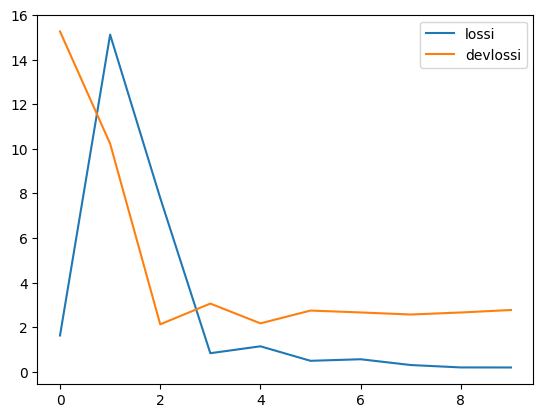

In [24]:
plt.plot(lossi, label="lossi")
plt.plot(devlossi, label="devlossi")
plt.legend()

In [41]:
ex = dataset['train'][44]
ex_text = ex['text']
ex_input = torch.tensor(ex['input_ids']).unsqueeze(dim=0)
ex_label = ex['label']

with torch.no_grad():
    pred = model(ex_input)

print(f'The test is: {ex_text}')
if ex_label == 0:
    print(f'The label is: [1, 0, 0]')
elif ex_label == 1:
    print(f'The label is: [0, 1, 0]')
else:
    print(f'The label is: [0, 0, 1]')

print(f'The pred is: {torch.softmax(pred, dim=1)}')

The test is: :visiting my friendster and facebook
The label is: [0, 1, 0]
The pred is: tensor([[0.1678, 0.8187, 0.0134]], device='cuda:1')
